In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt

In [2]:
data = loadmat("./data/data.mat")["data"].T
label = loadmat("./data/label.mat")["trueLabel"].T

In [3]:
data.shape,label.shape

((1990, 784), (1990, 1))

Text(0.5, 1.0, 'True label = 2')

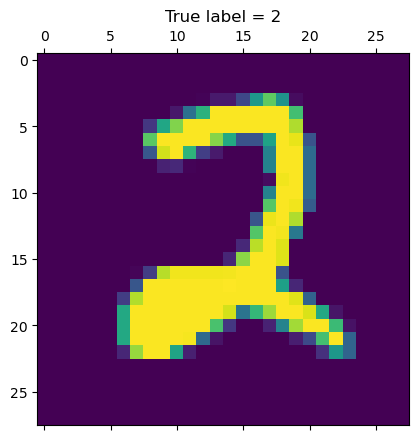

In [4]:
image_i=7
plt.matshow(data[image_i,:].reshape(28,28).T)
plt.title(f"True label = {label[image_i,0]}")

Text(0.5, 1.0, 'True label = 6')

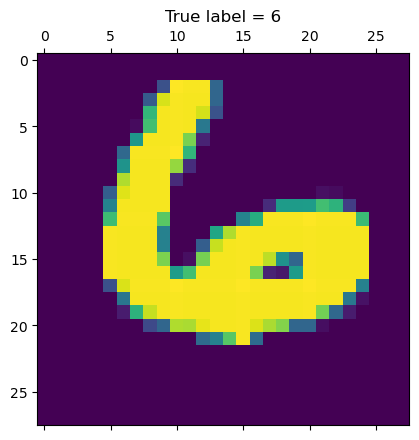

In [5]:
image_i=1600
plt.matshow(data[image_i,:].reshape(28,28).T)
plt.title(f"True label = {label[image_i,0]}")

### PCA on data

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(data)

PCA(n_components=5)

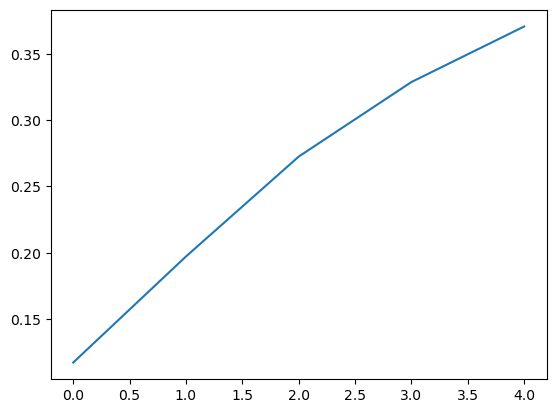

In [7]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [8]:
pca.singular_values_

array([109.67772186,  90.56129323,  87.90827795,  75.95430928,
        65.54887687])

In [9]:
data_pca = pca.transform(data)
data_pca.shape

(1990, 5)

### EM Algorithm

In [10]:
from scipy.stats import norm,multivariate_normal

In [11]:
N,D = data_pca.shape
C = 2

In [12]:
#mixing proportion
pi = np.random.uniform(size=(C,1))
pi = pi/pi.sum()
pi

array([[0.24199664],
       [0.75800336]])

In [31]:
#mu
mu = np.random.normal(size=(D,C))
print ("mu shape",mu.shape)
#Sigma
s1 = np.random.normal(size=(D,D))
s2 = np.random.normal(size=(D,D))
sigma1 = (s1 @ s1.T) + np.identity(D)
sigma2 = (s2 @ s2.T) + np.identity(D)
Sigma = np.array([sigma1,sigma2])
print ("Sigma shape",Sigma.shape)
#tau
tau = np.zeros(shape=(N,C))
print ("tau shape",tau.shape)

mu shape (5, 2)
Sigma shape (2, 5, 5)
tau shape (1990, 2)


### E-step
$$\tau_c = \pi_c + \mathcal{N}(X|\mu_c,\Sigma_c)$$

### M-step
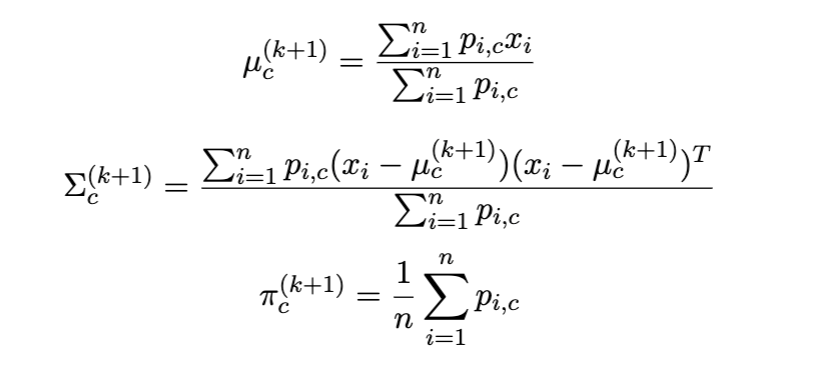

In [33]:
def e_step(X,tau,pi,mu,Sigma):
    _,C=mu.shape
    N,D = X.shape
    for c in range(C):
        mu_c = mu[:,c]
        sigma_c = Sigma[c,:,:]
        tau[:,c] = pi[c] * multivariate_normal.pdf(X,mean=mu_c,cov=sigma_c)
#     print (tau.shape)
    log_lik = np.log(tau.sum(axis=1)).sum()
    tau = tau/tau.sum(axis=1).reshape(N,1)
    return (tau,log_lik)

In [34]:
def m_step(pi,tau,X,mu,Sigma):
    #update pi
    pi = tau.mean(axis=0)
    #update mu
    N,C = tau.shape
    for c in range(C):
        tau_c = tau[:,c].reshape(N,1)
#         print (tau_c.shape,X.shape,(tau_c * X).sum(axis=0).shape)
        mu[:,c] = (tau_c * X).sum(axis=0)/(tau[:,c].sum())
        X_dev = X-mu[:,c]
        Sigma[c,:,:] = (X_dev.T@np.diag(tau[:,c])@X_dev)/(tau[:,c].sum())
    return (pi,mu,Sigma)

In [60]:
np.random.normal(size=(D,C))

array([[ 0.03167663,  1.52976045],
       [-1.28162659, -1.17579042],
       [-0.41113762, -0.09569713],
       [-0.98204592, -1.70122649],
       [-0.30248403,  1.42080926]])

mu shape (5, 2)


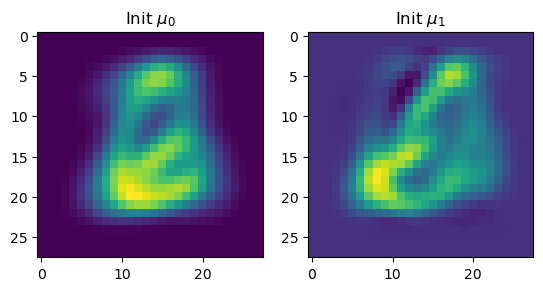

Sigma shape (2, 5, 5)


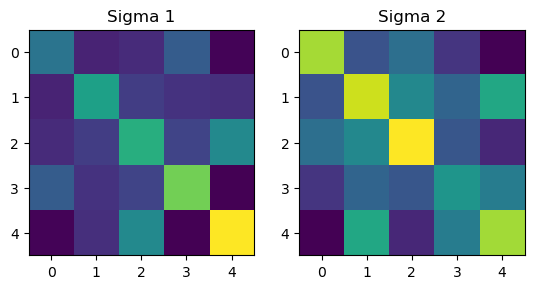

tau shape (1990, 2)


In [79]:
N_iter=25
#init
#mu
mu = np.random.normal(size=(D,C))
print ("mu shape",mu.shape)
mu_pca_0 = mu[:,0]
mu_pca_1 = mu[:,1]
#inverse transform
mu_0 = pca.inverse_transform(mu_pca_0.copy()).reshape(28,28).T
mu_1 = pca.inverse_transform(mu_pca_1.copy()).reshape(28,28).T
fig,axes=plt.subplots(1,2)
axes[0].imshow(mu_0)
axes[0].set_title(f"Init $\mu_0$")
axes[1].imshow(mu_1)
axes[1].set_title(f"Init $\mu_1$")
plt.show()

#Sigma
s1 = np.random.normal(size=(D,D))
s2 = np.random.normal(size=(D,D))
sigma1 = (s1 @ s1.T) + np.identity(D)
sigma2 = (s2 @ s2.T) + np.identity(D)
Sigma = np.array([sigma1,sigma2])
print ("Sigma shape",Sigma.shape)
fig,axes=plt.subplots(1,2)
axes[0].imshow(Sigma[0,:,:])
axes[0].set_title("Sigma 1")
axes[1].imshow(Sigma[1,:,:])
axes[1].set_title("Sigma 2")
plt.show()

#tau
tau = np.zeros(shape=(N,C))
print ("tau shape",tau.shape)

Text(0.5, 1.0, 'Convergence of $Likelihood$')

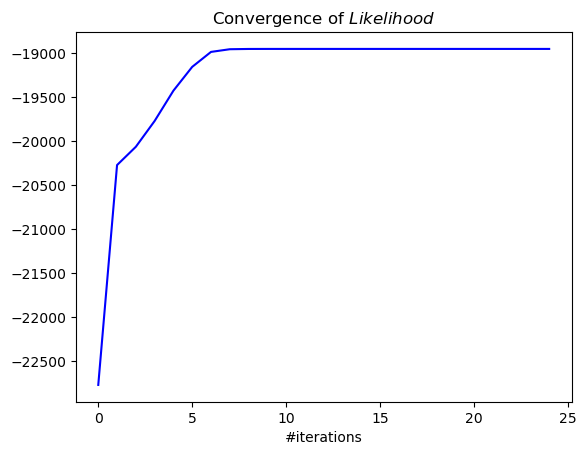

In [80]:
mu_list=[]
log_lik_list=[]

mu_i = mu
for cnt in range(N_iter):
    #do e_step
    tau,log_lik_i = e_step(data_pca,tau,pi,mu_i,Sigma)
    log_lik_list.append(log_lik_i)
    #do m-step
    pi,mu_i,Sigma = m_step(pi,tau,data_pca,mu_i,Sigma)
    #get log_lik
    mu_list.append(mu_i.copy())
    
plt.plot(log_lik_list,"b-")
plt.xlabel("#iterations")
plt.title("Convergence of $Likelihood$")

In [204]:
print ("final pi")
pi

final pi


array([0.49313392, 0.50686608])

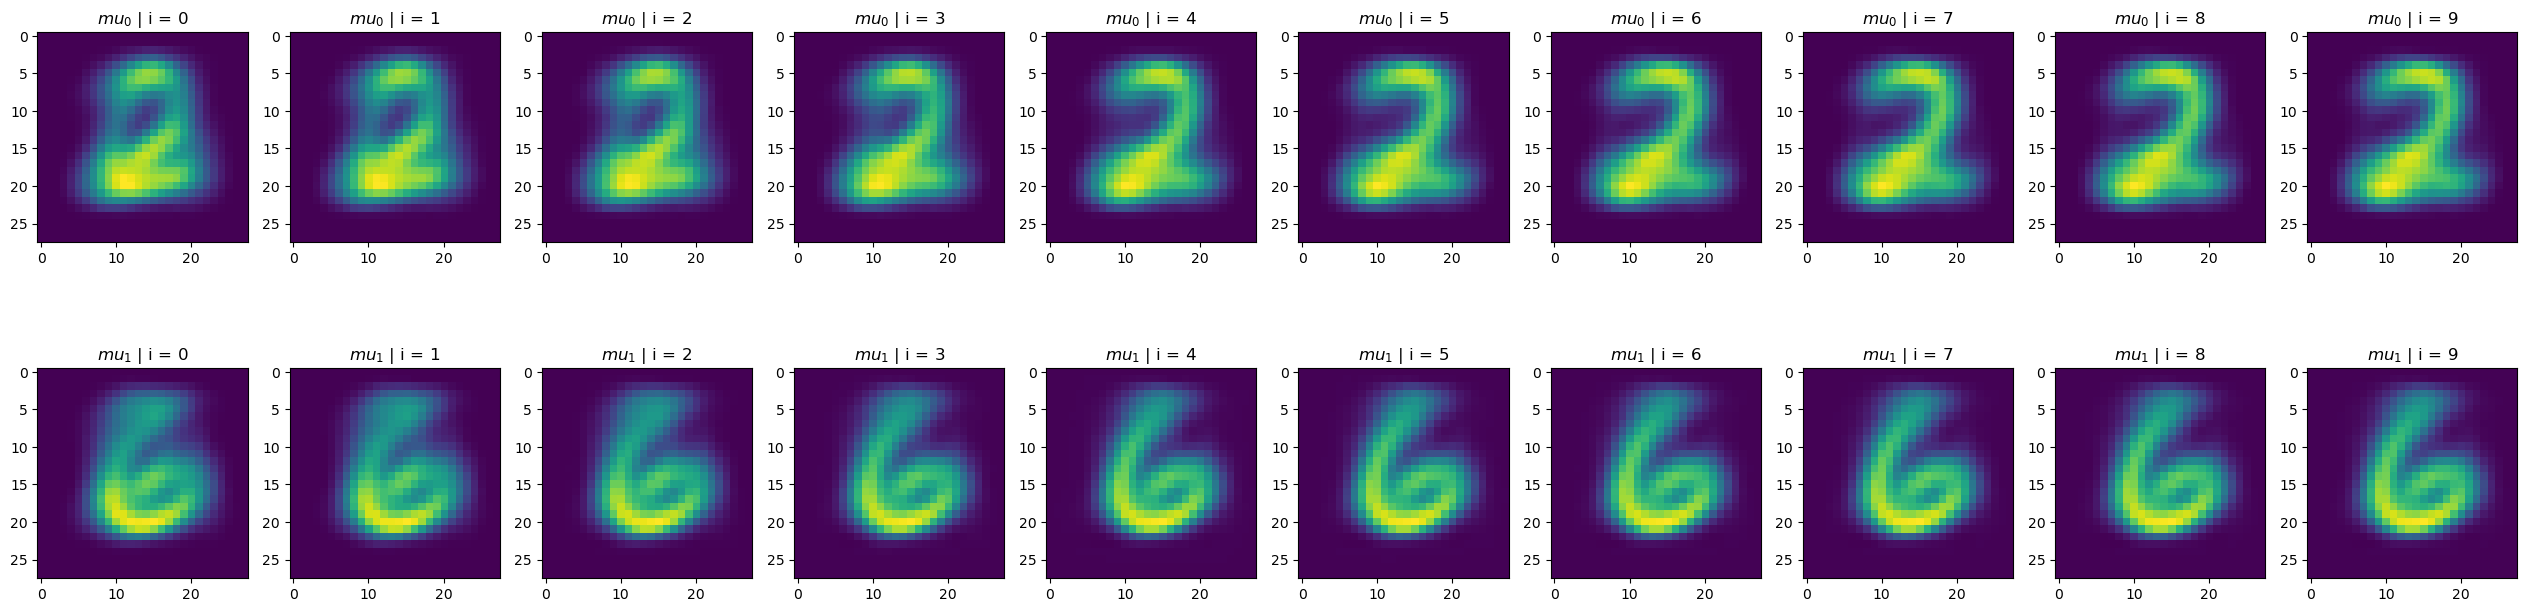

In [82]:
#plot change in mu
steps=10
fig,axes=plt.subplots(2,steps,figsize=(32,8))

for i,mu_i in enumerate(mu_list[:steps]):
    if True:
        #retrieve
        mu_pca_0 = mu_i[:,0]
        mu_pca_1 = mu_i[:,1]
        #inverse transform
        mu_0 = pca.inverse_transform(mu_pca_0.copy()).reshape(28,28).T
        mu_1 = pca.inverse_transform(mu_pca_1.copy()).reshape(28,28).T
        axes[0][int(i)].imshow(mu_0)
        axes[0][int(i)].set_title(f"$mu_0$ | i = {i}")
        axes[1][int(i)].imshow(mu_1)
        axes[1][int(i)].set_title(f"$mu_1$ | i = {i}")

Final mu


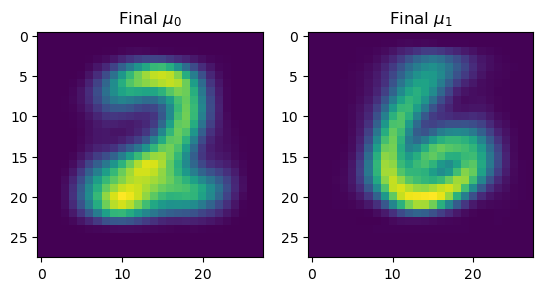

In [85]:
print ("Final mu")
mu_pca_0 = mu_list[-1][:,0]
mu_pca_1 = mu_list[-1][:,1]
#inverse transform
mu_0 = pca.inverse_transform(mu_pca_0.copy()).reshape(28,28).T
mu_1 = pca.inverse_transform(mu_pca_1.copy()).reshape(28,28).T
fig,axes=plt.subplots(1,2)
axes[0].imshow(mu_0)
axes[0].set_title(f"Final $\mu_0$")
axes[1].imshow(mu_1)
axes[1].set_title(f"Final $\mu_1$")
plt.show()

In [149]:
eig_vetors = pca.components_
e = eig_vetors * pca.explained_variance_.reshape(5,1)
e.shape

(5, 784)

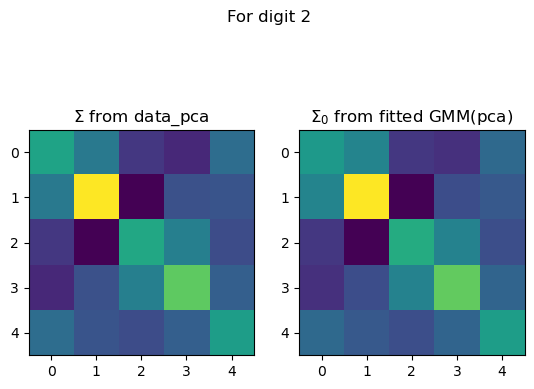

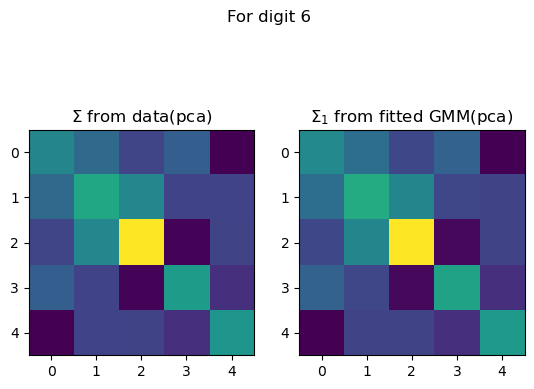

In [181]:
fig,axes=plt.subplots(1,2)
axes[0].imshow(np.cov(data_pca[(label==2)[:,0],:].T))
axes[0].set_title(f"$\Sigma$ from data_pca")
axes[1].imshow(Sigma[0,:,:])
axes[1].set_title(f"$\Sigma_0$ from fitted GMM(pca)")
plt.suptitle("For digit 2")
plt.show()

fig,axes=plt.subplots(1,2)
axes[0].imshow(np.cov(data_pca[(label==6)[:,0],:].T))
axes[0].set_title(f"$\Sigma$ from data(pca)")
# axes[0].colorbar()
axes[1].imshow(Sigma[1,:,:])
# axes[1].colorbar()
axes[1].set_title(f"$\Sigma_1$ from fitted GMM(pca)")
plt.suptitle("For digit 6")
plt.show()

In [186]:
eig_vetors.shape

(5, 784)

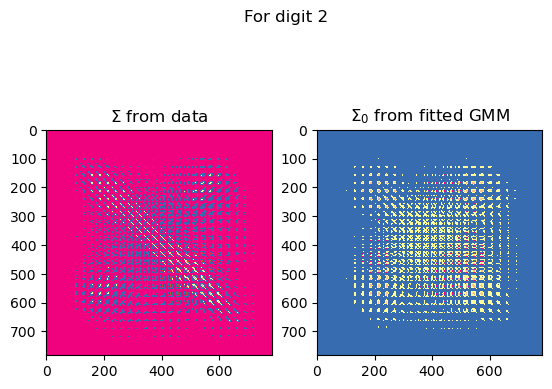

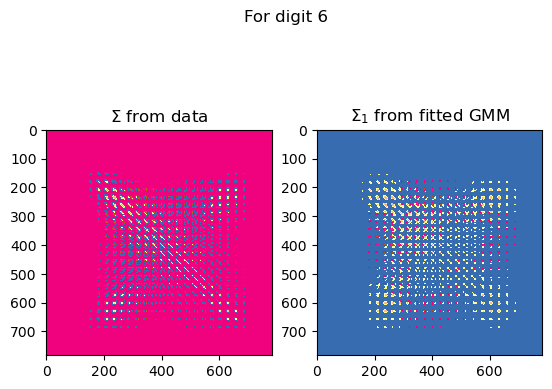

In [211]:
fig,axes=plt.subplots(1,2)
axes[0].imshow(np.cov(data[(label==2)[:,0],:].T),cmap=plt.cm.Accent_r)
axes[0].set_title(f"$\Sigma$ from data")
axes[1].imshow(eig_vetors.T @ Sigma[0,:,:] @ eig_vetors ,cmap=plt.cm.Accent_r)
axes[1].set_title(f"$\Sigma_0$ from fitted GMM")
plt.suptitle("For digit 2")
plt.show()

fig,axes=plt.subplots(1,2)
axes[0].imshow(np.cov(data[(label==6)[:,0],:].T),cmap=plt.cm.Accent_r)
axes[0].set_title(f"$\Sigma$ from data")
# axes[0].colorbar()
axes[1].imshow(eig_vetors.T @ Sigma[1,:,:] @ eig_vetors,cmap=plt.cm.Accent_r)
# axes[1].colorbar()
axes[1].set_title(f"$\Sigma_1$ from fitted GMM")
plt.suptitle("For digit 6")
plt.show()

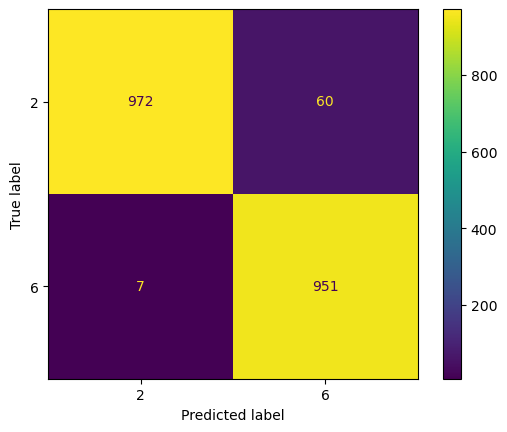

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
label_pred = np.where(np.argmax(tau,axis=1)==0,2,6)
ConfusionMatrixDisplay.from_predictions(y_true=label,y_pred=label_pred)

In [1]:
(60+7)/(1990)

0.033668341708542715

### Compare with k-means

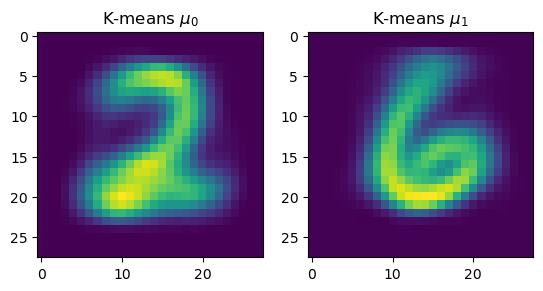

In [202]:
from sklearn.cluster import KMeans
kmeans = KMeans(init="k-means++", n_clusters= 2, n_init=5, random_state=0)
kmeans.fit(data_pca)
mu_kmeans = kmeans.cluster_centers_.T

mu_0 = pca.inverse_transform(mu_kmeans[:,0].copy()).reshape(28,28).T
mu_1 = pca.inverse_transform(mu_kmeans[:,1].copy()).reshape(28,28).T
fig,axes=plt.subplots(1,2)
axes[0].imshow(mu_0)
axes[0].set_title(f"K-means $\mu_0$")
axes[1].imshow(mu_1)
axes[1].set_title(f"K-means $\mu_1$")
plt.show()

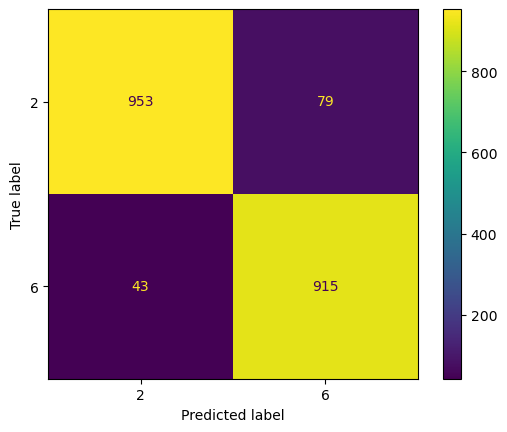

In [203]:
label_pred_kmeans = kmeans.predict(data_pca)
label_pred_kmeans = np.where(label_pred_kmeans==0,2,6)
ConfusionMatrixDisplay.from_predictions(y_true=label,y_pred=label_pred_kmeans)

In [2]:
(79+43)/1990

0.061306532663316586